# 3 Period Korean Analysis

## [1. Moduel Import]

## [2. Data Load]

## [3. Preprocess]
#### 3-1) Data Cleaning
- 특수 문자 등 제거

#### 3-2) Tagging
- kkma를 이용하여 형태소 분석

#### 3-3) Remove Stopword
- 불용어 제거

#### 3-4) Tokenize
- LDA Modeling에 사용할 수 있도록 Token화

## [4. Analysis]
#### 4-1) Frequency
- 분석 1) 전체 Text에서의 Frequency (상위 30개)
- 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율
- 분석 3) 'noun'인 token들의 Frequncy (상위 30개)
- 분석 4) 'verb'인 token들의 Frequncy (상위 30개)
- 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)
- 각 분석에 대해 StopWord 제거 이전과 이후에 대한 시각화를 모두 진행하였습니다.

#### 4-2) Topic Modeling (LDA)
- 토픽의 개수(NUM_TOPICS(= k))는 각 시기 당 할당된 기사의 수가 10개 이기 때문에 10으로 설정하였습니다.
- 실험적으로 최적의 k 값을 찾아나갈 예정입니다.
- Modeling에는 noun Token들만 추출하여 LDA 분석하였습니다.

#### 4-3) WordCloud
- 각 시기 별 Token들의 WordCloud
- noun token들만을 추출하여 WordCloud를 시각화하였습니다.

#### ~~4-4) Network web analysis~~
- 연관 관계 계산과정에서 실행시간이 오래 걸려서 먼저 완성할 수 있는 시각화 분석을 먼저 수행하였습니다.

## 1. Module Import

In [1]:
# self defined moduels
from myModules.TT.DataLoader import DataLoader
from myModules.TT.cleaning import cleaning
from myModules.TT.tagging import kkmaTagging
from myModules.TT.stopword import removeStopWord
from myModules.TT.tokenizing import tokenizing
from myModules.TT.mergeOverPeriod import merge
from myModules.TT.plotFrequency import calcTags, CountNLabelOverPOS, showCountNRate, tag2csv,plotOverallFrequency ,plotTagFrequency, plotPOSFrequency
from myModules.TT.ldaModeling import buildDTM, topicWords, visualizeLDA
from myModules.TT.plotWordCloud import plotWordCloud


# General Module
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
## tweepy version prob => install tweepy with version 3.9.0 
from gensim import models
from apyori import apriori


# Visualization
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_TT/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_TT/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_TT/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/TT/'
RESULT_2 = RESULT_ROOT + '/2시기/TT/'
RESULT_3 = RESULT_ROOT + '/3시기/TT/'

In [3]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1)
texts_2 = DataLoader(files_2)
texts_3 = DataLoader(files_3)

## 3. Preprocess

### 3-1. Data Cleaning

In [4]:
cleaned_1 = cleaning(texts_1)
cleaned_2 = cleaning(texts_2)
cleaned_3 = cleaning(texts_3)

### 3-2. Taggging

In [5]:
tagged_1 = kkmaTagging(cleaned_1)
tagged_2 = kkmaTagging(cleaned_2)
tagged_3 = kkmaTagging(cleaned_3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-3. Remove Stopword

#### Tag List 정의

In [6]:
tagList = [['noun', ['NN','NNS','NNP','NNPS'], ['NNG','NNB','NNP','NNM']], \
    ['pronoun', ['PRP','WP','PRP'], ['NP']],
    ['verb', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], ['VV', 'VXV', 'VCP']],
    ['adjective', ['JJ', 'JJR', 'JJS'], ['VA', 'VXA', 'VCN']],
    ['adverb', ['RB', 'RBR', 'RBS', 'WRB', 'EX', 'RP'], ['MAG']],
    ['prep&conj', ['TO', 'IN', 'CC'], ['MAC']],
    ['determiner', ['DT', 'PDT', 'WDT'], ['MDT', 'MDN']],
    ['interjection',['UH'], ['IC']],
    ['number', ['CD'], ['NR', 'ON']],
    ['foreignW', ['FW'],['OL']],
    ['modal',['MD'],[]],
    ['josa', [], ['JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX']],
    ['possesiveS', ['POS'], []],
    ['others',['LS'], ['EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD', 'XPN', 'XPV', 'XSN', 'XSV', 'XSA', 'XR', 'UN', 'OH']]]

tagList = pd.DataFrame(tagList)
tagList.columns = ['POS', 'Eng_tag', 'Kor_tag']

#### Stopword 정의

Stopword는 다음과 같이 설정하였습니다.
- 감탄사 : 'IC'
- 조사 : 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX'
- 어미 : 'EPH', 'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD'
- 접두사 : 'XPN', 'XPV'
- 접미사 : 'XSN', 'XSV', 'XSA'
- 어근 : 'XR'
- 명사추정범주 : 'UN'
- 한자 : 'OH'
- 외국어 : 'OL'
- 숫자 : 'ON'
- [https://www.ranks.nl/stopwords/korean](https://www.ranks.nl/stopwords/korean) 에 나타나 있는 보편적인 한국어 불용어

In [7]:
stop_tag_list = ['IC', 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX', 'EPH', \
    'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD',
    'XSN', 'XSV', 'XSA', 'UN', 'OH', 'OL', 'ON', 'XPN', 'XPV', 'XR']

Kor_stopwords = ''

with open("./Data/Kor_stopwords.txt", 'r', encoding='utf-8') as f:
    stopword = f.read()
    Kor_stopwords = stopword

Kor_stopwords = Kor_stopwords.split('\n')

#### Stopword 제거

In [8]:
wo_stopword_1 = removeStopWord(tagged_1, stop_tag_list, Kor_stopwords)
wo_stopword_2 = removeStopWord(tagged_2, stop_tag_list, Kor_stopwords)
wo_stopword_3 = removeStopWord(tagged_3, stop_tag_list, Kor_stopwords)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

### 3-4. Tokenize

In [9]:
tokenized_1 = tokenizing(wo_stopword_1, tagList, 'all')
tokenized_2 = tokenizing(wo_stopword_2, tagList, 'all')
tokenized_3 = tokenizing(wo_stopword_3, tagList, 'all')

## 4. Analysis

### 4-1. Frequency

#### Period 1

In [10]:
countDict_1, classDict_1 = calcTags(merge(tagged_1), tagList)
wo_countDict_1, wo_classDict_1 = calcTags(merge(wo_stopword_1), tagList)

  0%|          | 0/94094 [00:00<?, ?it/s]

  0%|          | 0/28940 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

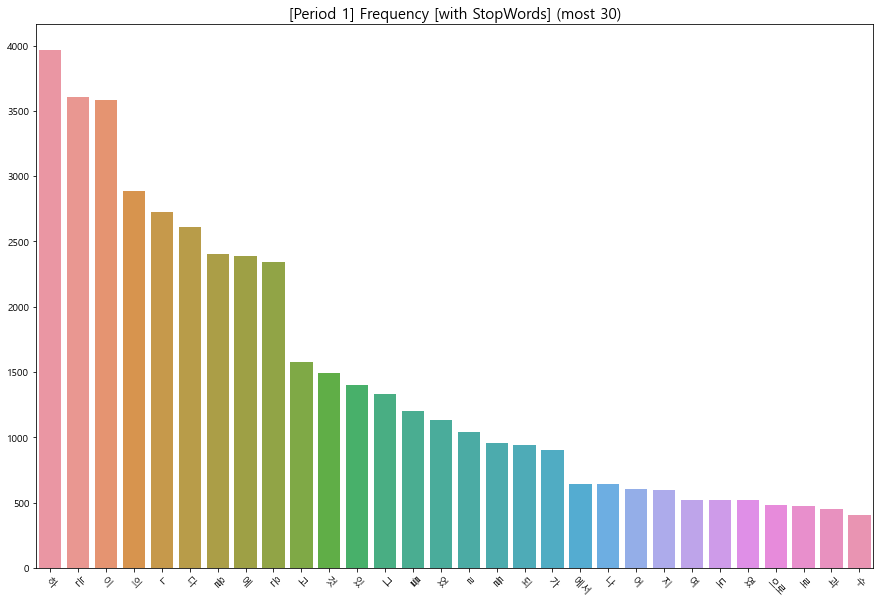

In [12]:
plotOverallFrequency(merge(tokenizing(tagged_1, tagList, pos='all')), filepath=RESULT_1+'Frequency/', wo=False, period=1)

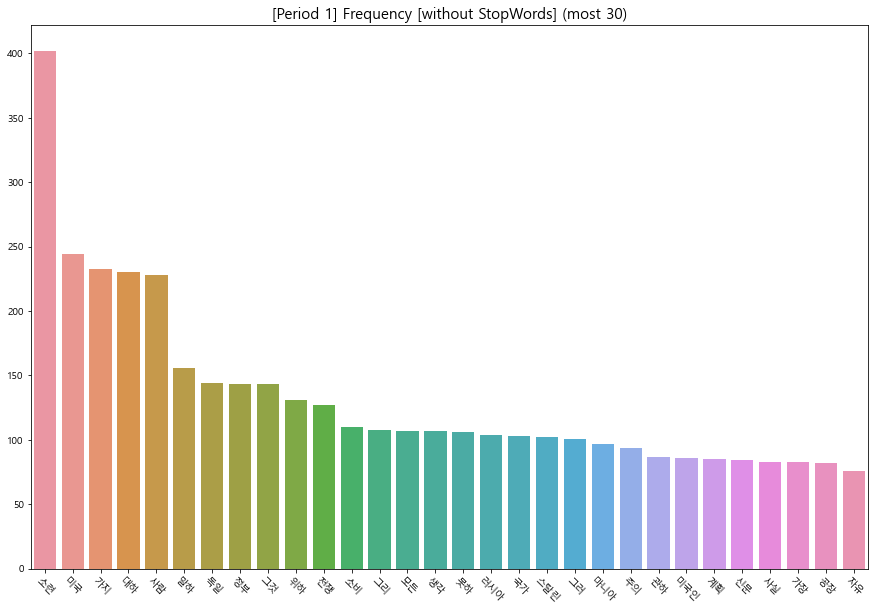

In [13]:
plotOverallFrequency(merge(tokenized_1), filepath=RESULT_1+'Frequency/', wo=True, period=1)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [14]:
showCountNRate(countDict_1, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 94094개
[noun] 토큰 수 : 30894개 | 비율 : 32.83%
[pronoun] 토큰 수 : 2286개 | 비율 : 2.43%
[verb] 토큰 수 : 10419개 | 비율 : 11.07%
[adjective] 토큰 수 : 1596개 | 비율 : 1.7%
[adverb] 토큰 수 : 3110개 | 비율 : 3.31%
[prepnconj] 토큰 수 : 237개 | 비율 : 0.25%
[determiner] 토큰 수 : 1522개 | 비율 : 1.62%
[interjection] 토큰 수 : 5개 | 비율 : 0.01%
[number] 토큰 수 : 232개 | 비율 : 0.25%
[foreignW] 토큰 수 : 87개 | 비율 : 0.09%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 18744개 | 비율 : 19.92%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 24812개 | 비율 : 26.37%
-------------------------


In [15]:
showCountNRate(wo_countDict_1, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 28940개
[noun] 토큰 수 : 23104개 | 비율 : 79.83%
[pronoun] 토큰 수 : 207개 | 비율 : 0.72%
[verb] 토큰 수 : 3258개 | 비율 : 11.26%
[adjective] 토큰 수 : 571개 | 비율 : 1.97%
[adverb] 토큰 수 : 1462개 | 비율 : 5.05%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 151개 | 비율 : 0.52%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 84개 | 비율 : 0.29%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [16]:
tag2csv(countDict_1, classDict_1, tagList, RESULT_1 +'Frequency-in-POS/' + "Frequency over POS-withstopword")
tag2csv(wo_countDict_1, wo_classDict_1, tagList, RESULT_1  +'Frequency-in-POS/' + "Frequency over POS-withoutstopword")

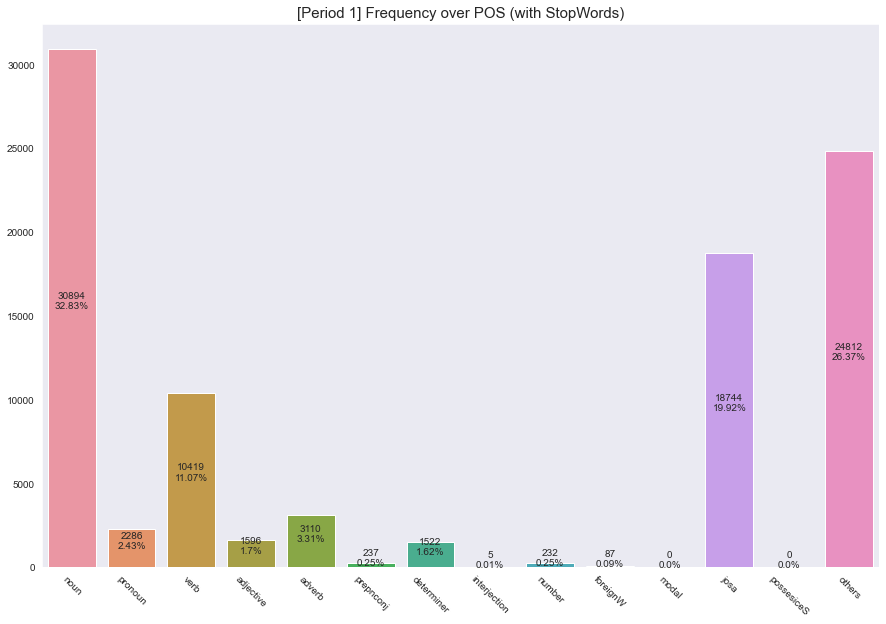

In [17]:
count, labels = CountNLabelOverPOS(countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (with StopWords)", RESULT_1 +'Frequency-in-POS/')

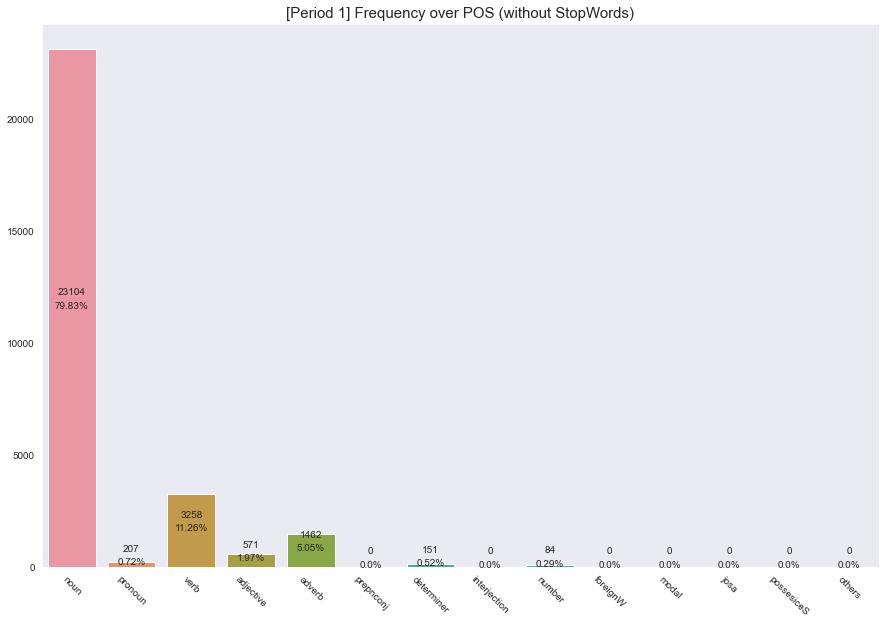

In [18]:
count, labels = CountNLabelOverPOS(wo_countDict_1)

plotTagFrequency(count, labels, "[Period 1] Frequency over POS (without StopWords)", RESULT_1 +'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

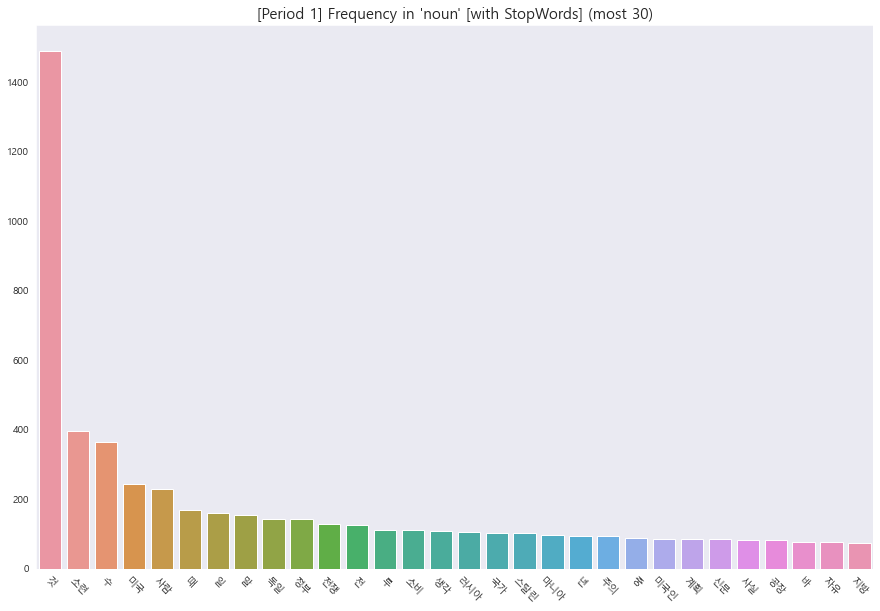

In [19]:
plotPOSFrequency(classDict_1, filepath=RESULT_1 +'Frequency-in-noun/', pos='noun', wo=False, period=1)

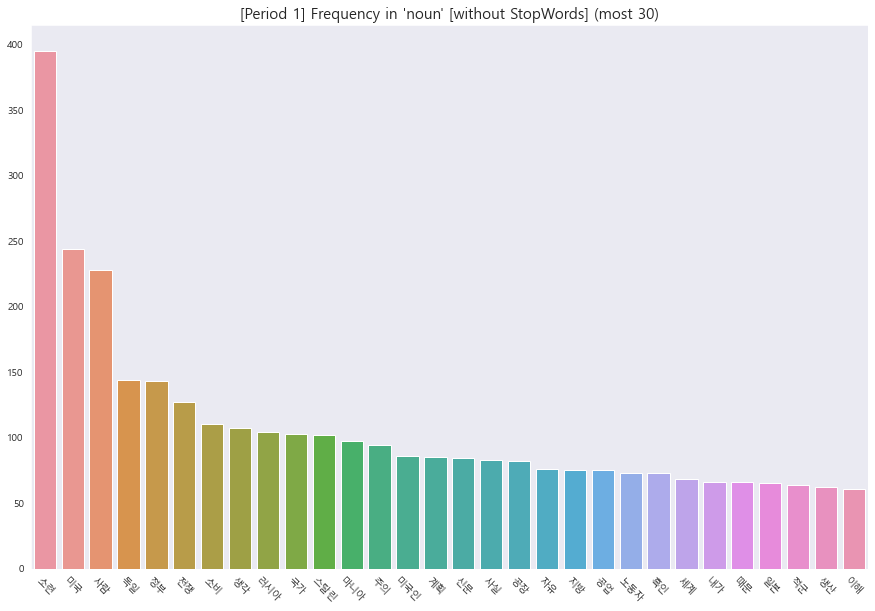

In [20]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1 +'Frequency-in-noun/', pos='noun', wo=True, period=1)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

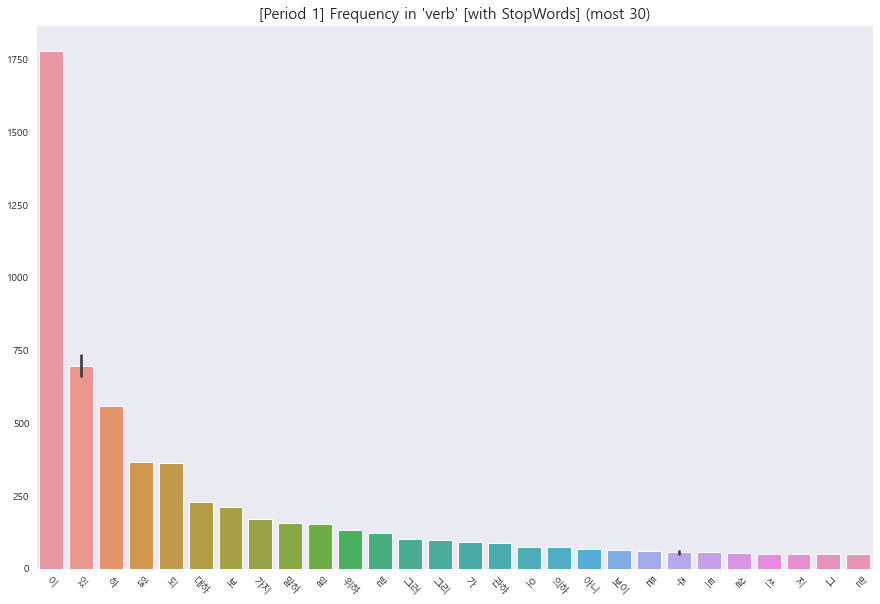

In [21]:
plotPOSFrequency(classDict_1, filepath=RESULT_1 +'Frequency-in-verb/', pos='verb', wo=False, period=1)

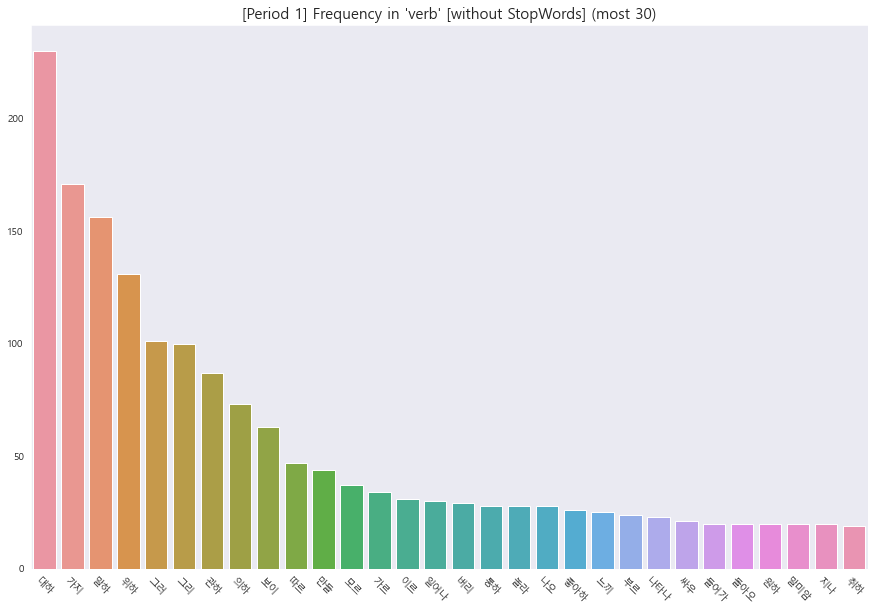

In [22]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1+'Frequency-in-verb/', pos='verb', wo=True, period=1)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

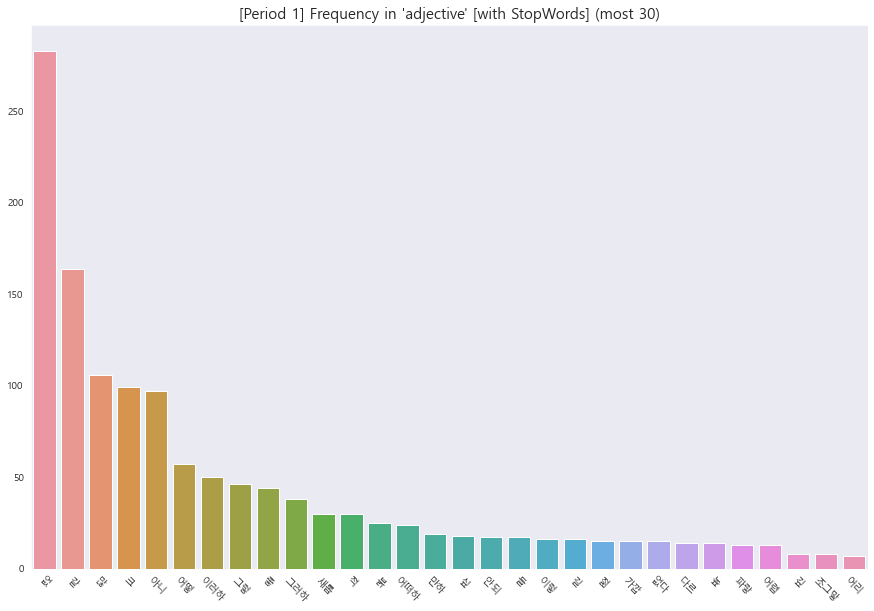

In [23]:
plotPOSFrequency(classDict_1, filepath=RESULT_1+'Frequency-in-adjective/', pos='adjective', wo=False, period=1)

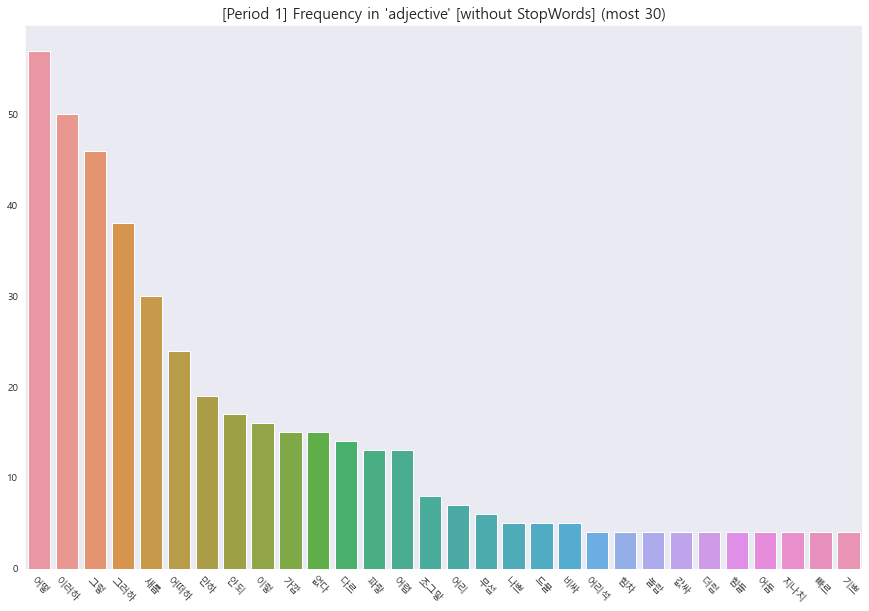

In [24]:
plotPOSFrequency(wo_classDict_1, filepath=RESULT_1+'Frequency-in-adjective/', pos='adjective', wo=True, period=1)

#### Period 2

In [25]:
countDict_2, classDict_2 = calcTags(merge(tagged_2), tagList)
wo_countDict_2, wo_classDict_2 = calcTags(merge(wo_stopword_2), tagList)

  0%|          | 0/38067 [00:00<?, ?it/s]

  0%|          | 0/12503 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

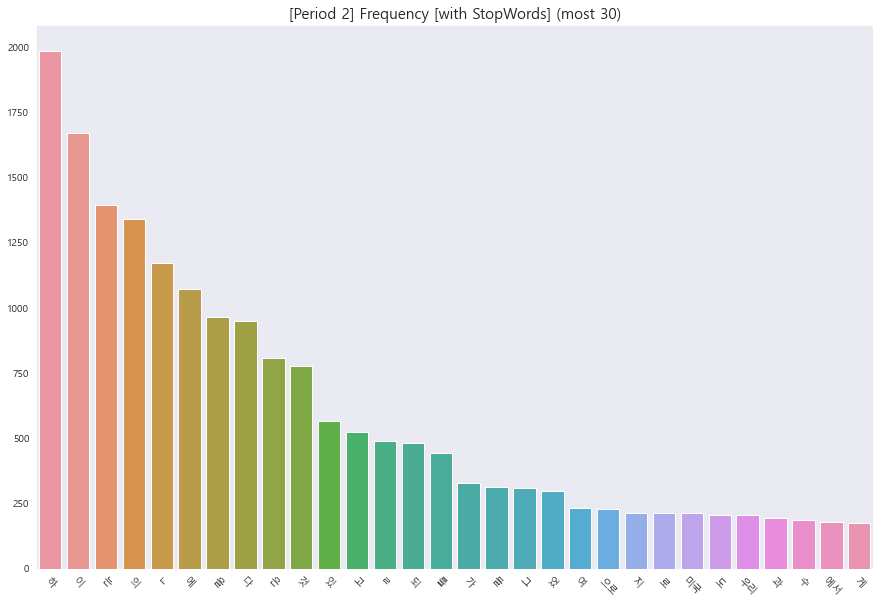

In [26]:
plotOverallFrequency(merge(tokenizing(tagged_2, tagList, pos='all')), filepath=RESULT_2+'Frequency/', wo=False, period=2)

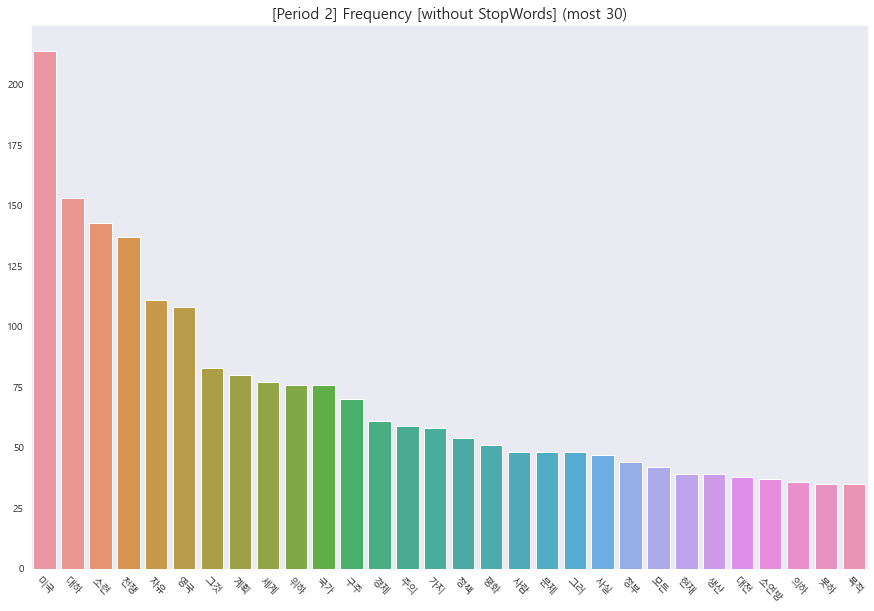

In [27]:
plotOverallFrequency(merge(tokenized_2), filepath=RESULT_2+'Frequency/', wo=True, period=2)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [28]:
showCountNRate(countDict_2, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 38067개
[noun] 토큰 수 : 13543개 | 비율 : 35.58%
[pronoun] 토큰 수 : 634개 | 비율 : 1.67%
[verb] 토큰 수 : 3775개 | 비율 : 9.92%
[adjective] 토큰 수 : 512개 | 비율 : 1.34%
[adverb] 토큰 수 : 1070개 | 비율 : 2.81%
[prepnconj] 토큰 수 : 121개 | 비율 : 0.32%
[determiner] 토큰 수 : 520개 | 비율 : 1.37%
[interjection] 토큰 수 : 4개 | 비율 : 0.01%
[number] 토큰 수 : 157개 | 비율 : 0.41%
[foreignW] 토큰 수 : 152개 | 비율 : 0.4%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 7579개 | 비율 : 19.91%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 9942개 | 비율 : 26.12%
-------------------------


In [29]:
showCountNRate(wo_countDict_2, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 12503개
[noun] 토큰 수 : 10507개 | 비율 : 84.04%
[pronoun] 토큰 수 : 99개 | 비율 : 0.79%
[verb] 토큰 수 : 1018개 | 비율 : 8.14%
[adjective] 토큰 수 : 188개 | 비율 : 1.5%
[adverb] 토큰 수 : 534개 | 비율 : 4.27%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 73개 | 비율 : 0.58%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 49개 | 비율 : 0.39%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [30]:
tag2csv(countDict_2, classDict_2, tagList, RESULT_2 +'Frequency-in-POS/' + "Frequency over POS-withstopword")
tag2csv(wo_countDict_2, wo_classDict_2, tagList, RESULT_2+'Frequency-in-POS/' + "Frequency over POS-withoutstopword")

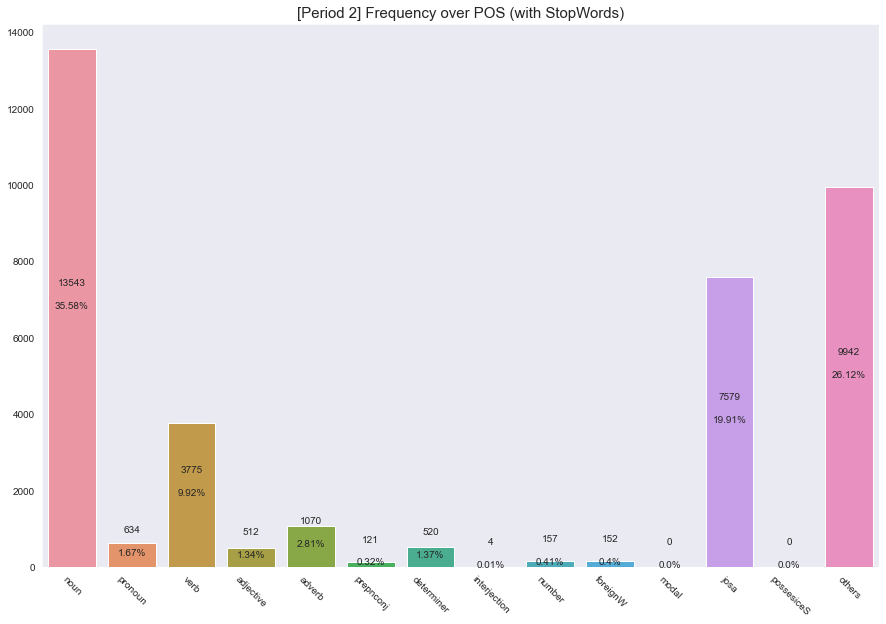

In [31]:
count, labels = CountNLabelOverPOS(countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (with StopWords)", RESULT_2+'Frequency-in-POS/')

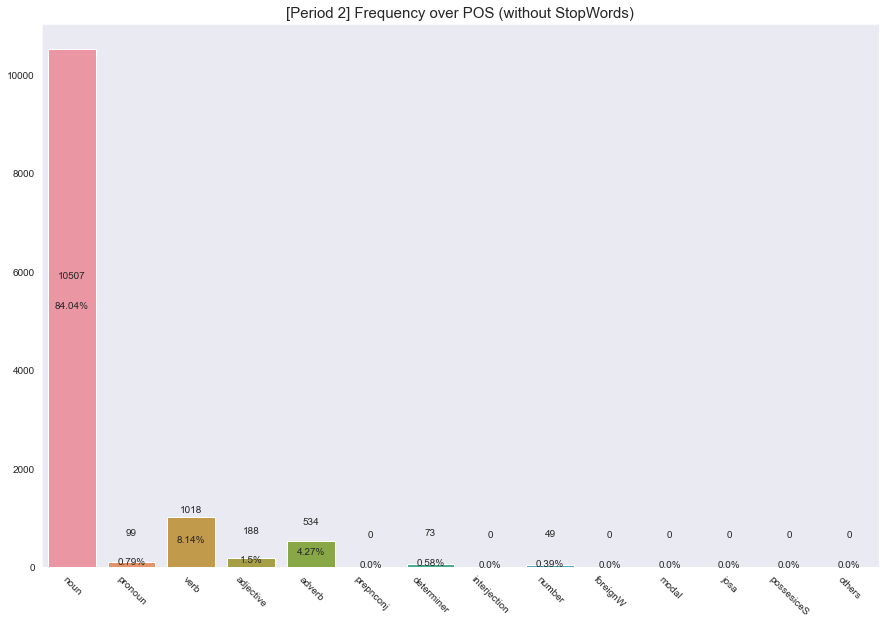

In [32]:
count, labels = CountNLabelOverPOS(wo_countDict_2)

plotTagFrequency(count, labels, "[Period 2] Frequency over POS (without StopWords)", RESULT_2+'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

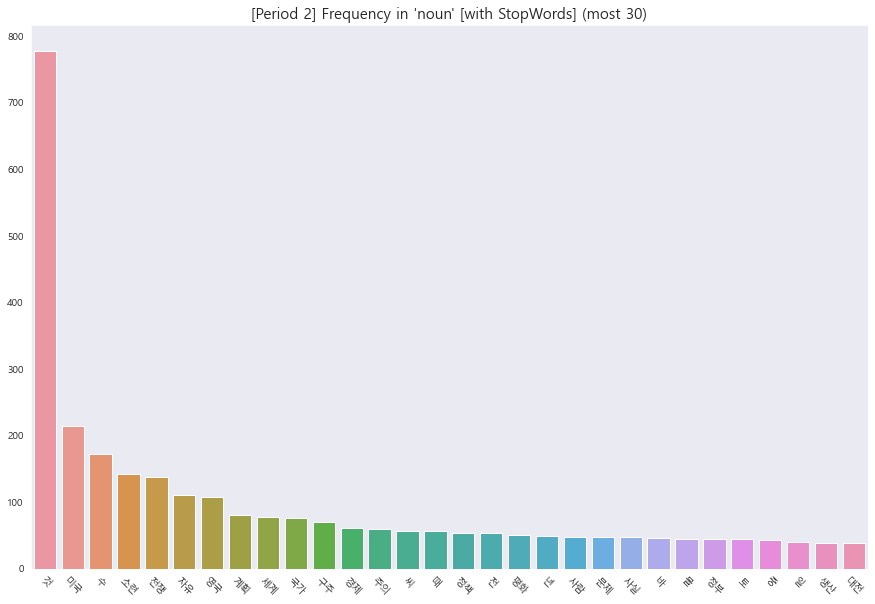

In [33]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-noun/', pos='noun', wo=False, period=2)

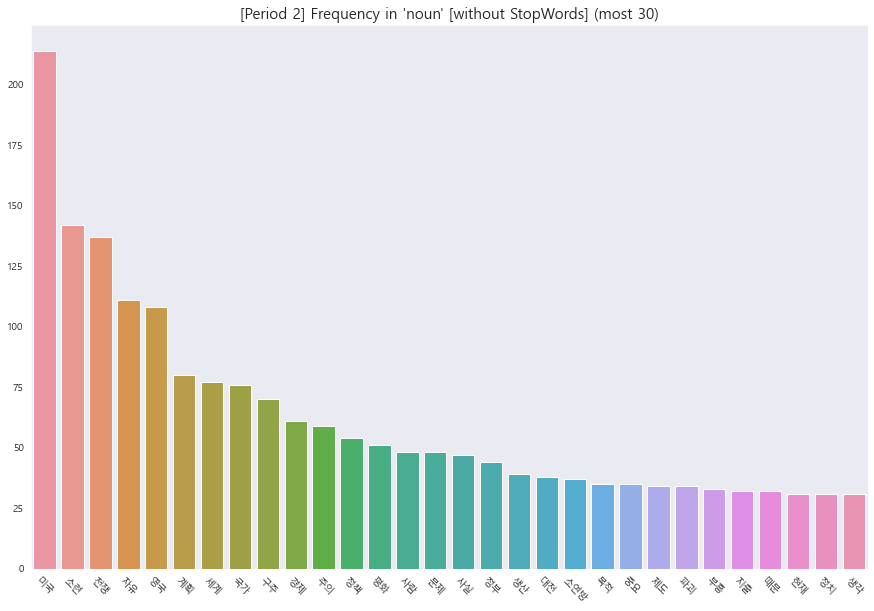

In [34]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-noun/', pos='noun', wo=True, period=2)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

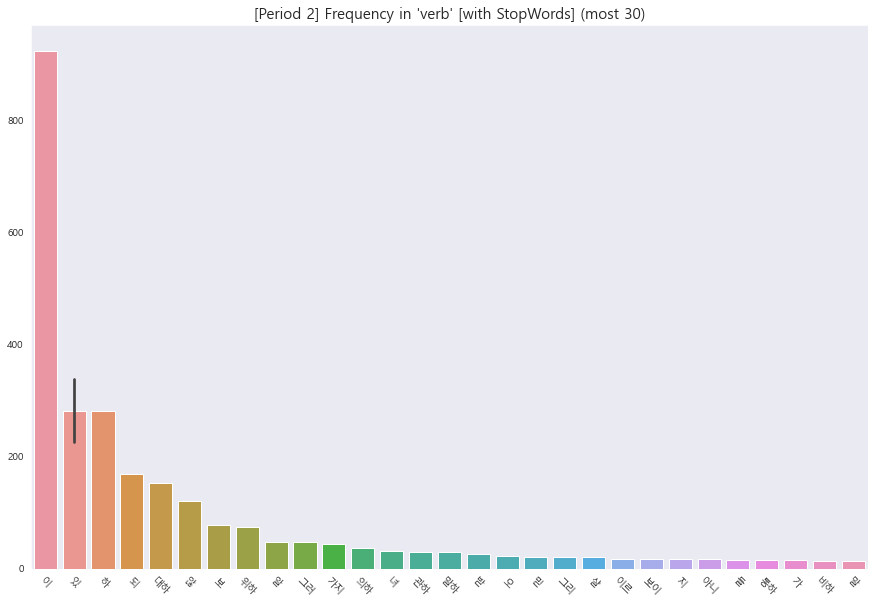

In [35]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-verb/', pos='verb', wo=False, period=2)

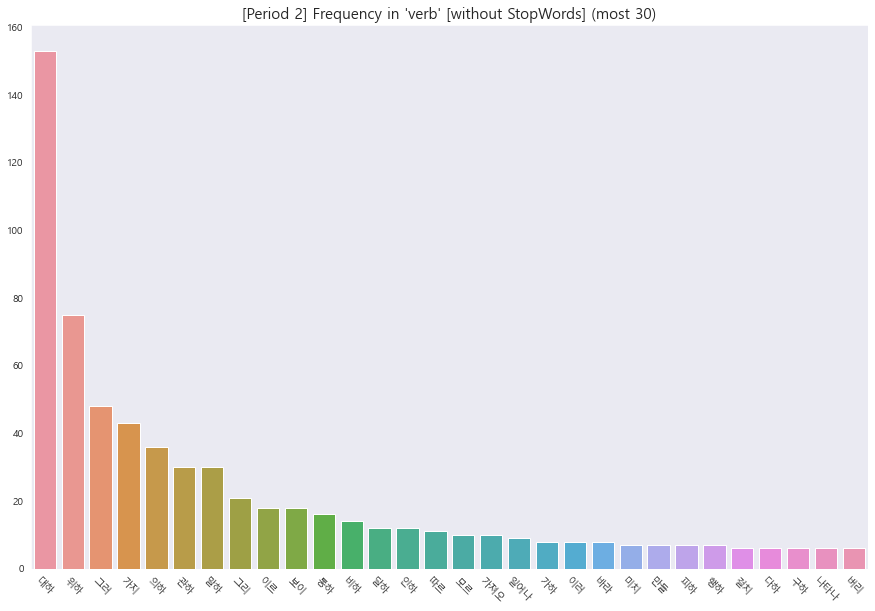

In [36]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-verb/', pos='verb', wo=True, period=2)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

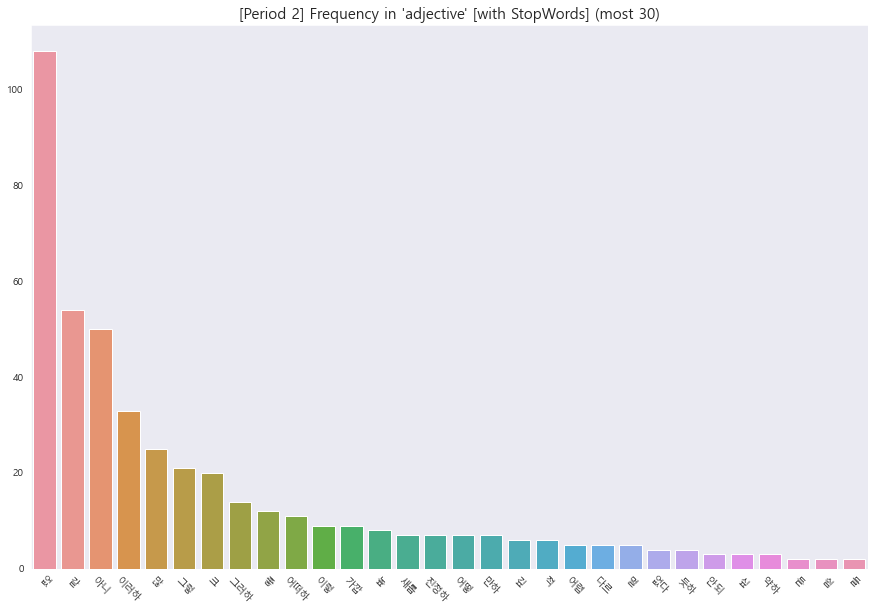

In [37]:
plotPOSFrequency(classDict_2, filepath=RESULT_2+'Frequency-in-adjective/', pos='adjective', wo=False, period=2)

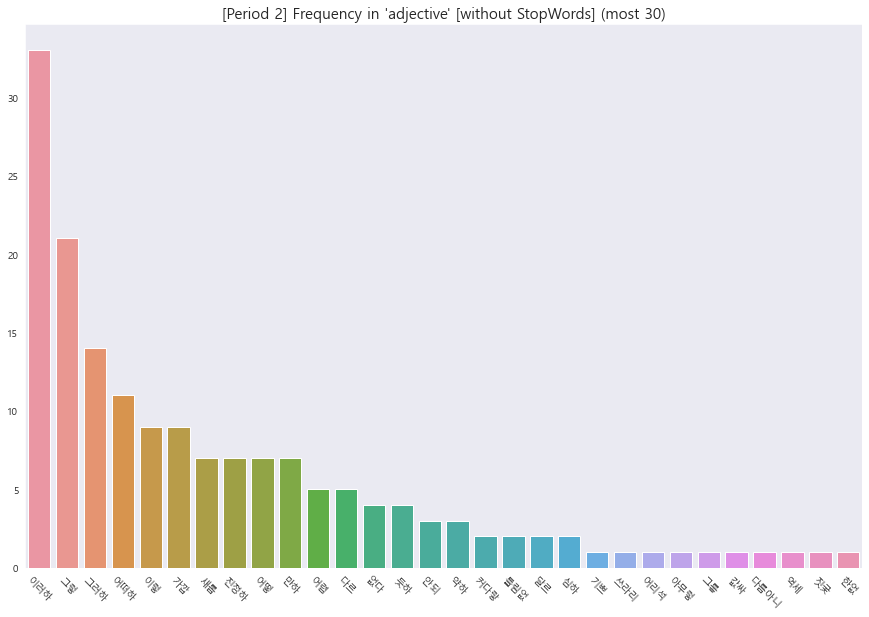

In [38]:
plotPOSFrequency(wo_classDict_2, filepath=RESULT_2+'Frequency-in-adjective/', pos='adjective', wo=True, period=2)

#### Period 3

In [39]:
countDict_3, classDict_3 = calcTags(merge(tagged_3), tagList)
wo_countDict_3, wo_classDict_3 = calcTags(merge(wo_stopword_3), tagList)

  0%|          | 0/58736 [00:00<?, ?it/s]

  0%|          | 0/19034 [00:00<?, ?it/s]

##### 분석 1) 전체 Text에서의 Frequency (상위 30개)

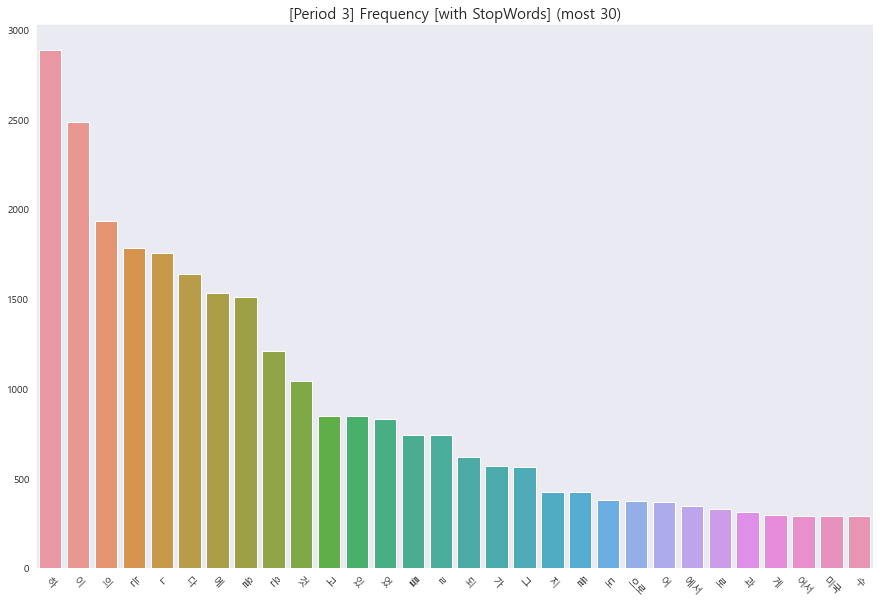

In [40]:
plotOverallFrequency(merge(tokenizing(tagged_3, tagList, pos='all')), filepath=RESULT_3+'Frequency/', wo=False, period=3)

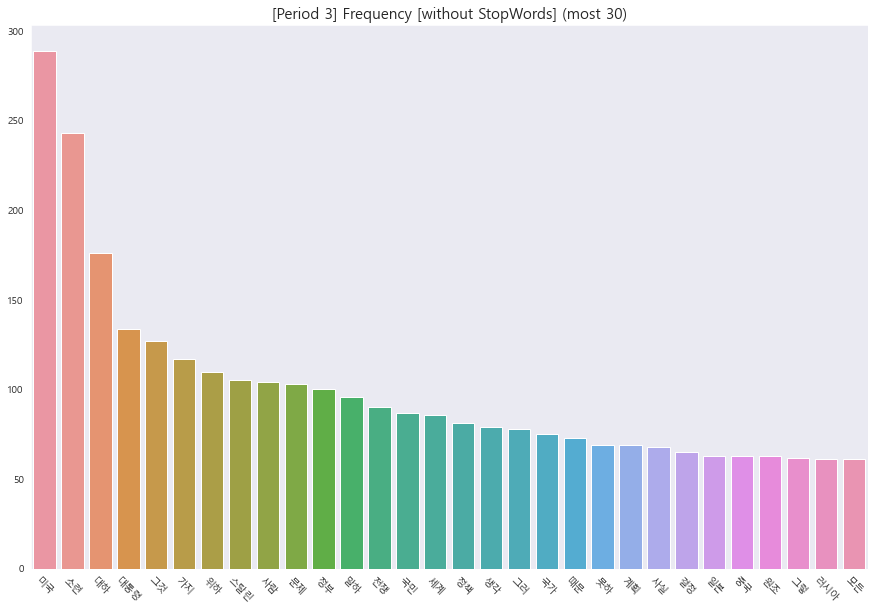

In [41]:
plotOverallFrequency(merge(tokenized_3), filepath=RESULT_3+'Frequency/', wo=True, period=3)

##### 분석 2) 각 POS('noun', 'verb', ...)별 분포와 비율

In [42]:
showCountNRate(countDict_3, "with Stopwords")

[with Stopwords]
-------------------------
전체 토큰 수 | 58736개
[noun] 토큰 수 : 20275개 | 비율 : 34.52%
[pronoun] 토큰 수 : 1010개 | 비율 : 1.72%
[verb] 토큰 수 : 6339개 | 비율 : 10.79%
[adjective] 토큰 수 : 943개 | 비율 : 1.61%
[adverb] 토큰 수 : 1531개 | 비율 : 2.61%
[prepnconj] 토큰 수 : 161개 | 비율 : 0.27%
[determiner] 토큰 수 : 849개 | 비율 : 1.45%
[interjection] 토큰 수 : 6개 | 비율 : 0.01%
[number] 토큰 수 : 138개 | 비율 : 0.23%
[foreignW] 토큰 수 : 43개 | 비율 : 0.07%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 11720개 | 비율 : 19.95%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 15619개 | 비율 : 26.59%
-------------------------


In [43]:
showCountNRate(wo_countDict_3, "without Stopwords")

[without Stopwords]
-------------------------
전체 토큰 수 | 19034개
[noun] 토큰 수 : 15541개 | 비율 : 81.65%
[pronoun] 토큰 수 : 172개 | 비율 : 0.9%
[verb] 토큰 수 : 1867개 | 비율 : 9.81%
[adjective] 토큰 수 : 393개 | 비율 : 2.06%
[adverb] 토큰 수 : 868개 | 비율 : 4.56%
[prepnconj] 토큰 수 : 0개 | 비율 : 0.0%
[determiner] 토큰 수 : 95개 | 비율 : 0.5%
[interjection] 토큰 수 : 0개 | 비율 : 0.0%
[number] 토큰 수 : 31개 | 비율 : 0.16%
[foreignW] 토큰 수 : 0개 | 비율 : 0.0%
[modal] 토큰 수 : 0개 | 비율 : 0.0%
[josa] 토큰 수 : 0개 | 비율 : 0.0%
[possesiceS] 토큰 수 : 0개 | 비율 : 0.0%
[others] 토큰 수 : 0개 | 비율 : 0.0%
-------------------------


In [44]:
tag2csv(countDict_3, classDict_3, tagList, RESULT_3 +'Frequency-in-POS/' + "Frequency over POS-withstopword")
tag2csv(wo_countDict_3, wo_classDict_3, tagList, RESULT_3 +'Frequency-in-POS/' + "Frequency over POS-withoutstopword")

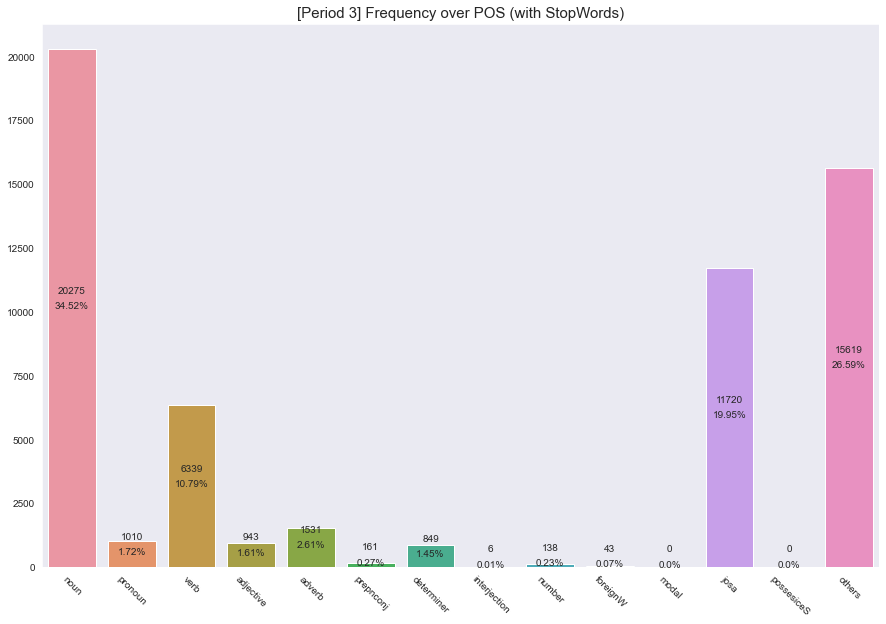

In [45]:
count, labels = CountNLabelOverPOS(countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (with StopWords)", RESULT_3+'Frequency-in-POS/')

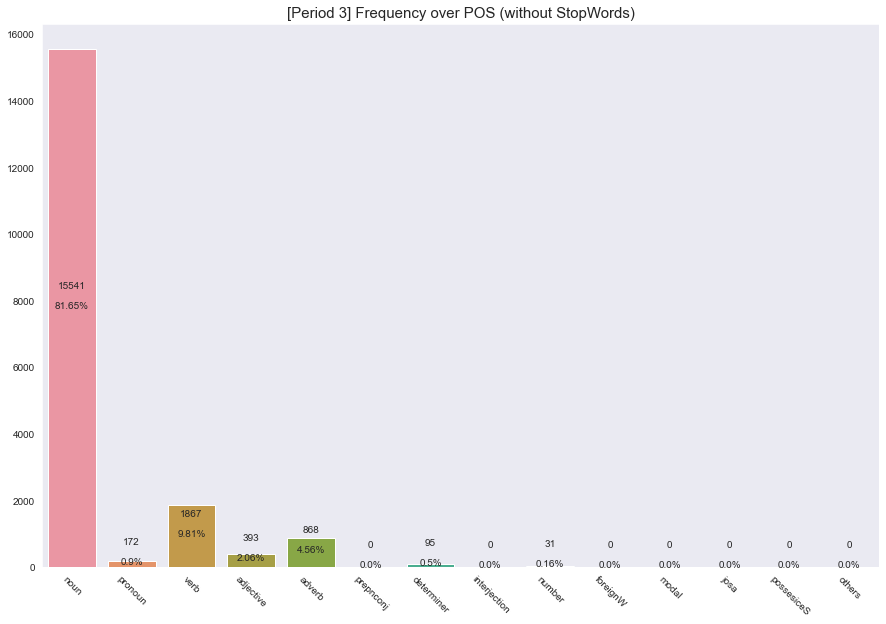

In [46]:
count, labels = CountNLabelOverPOS(wo_countDict_3)

plotTagFrequency(count, labels, "[Period 3] Frequency over POS (without StopWords)", RESULT_3+'Frequency-in-POS/')

##### 분석 3) 'noun'인 token들의 Frequncy (상위 30개)

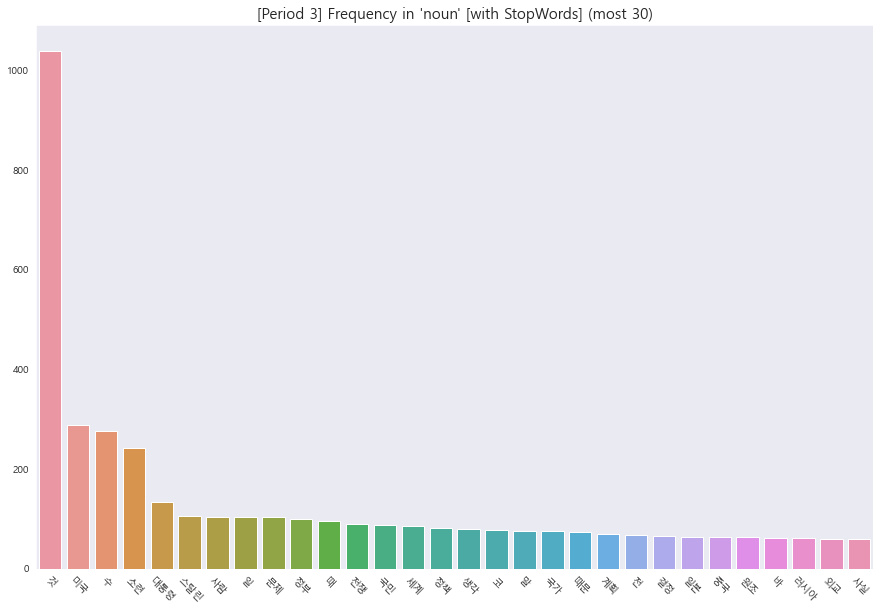

In [47]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-noun/', pos='noun', wo=False, period=3)

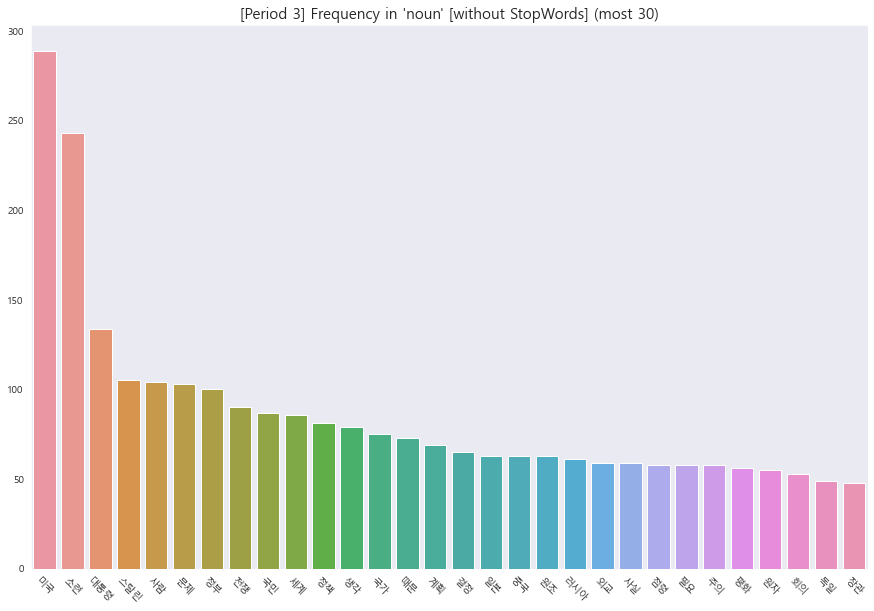

In [48]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-noun/', pos='noun', wo=True, period=3)

##### 분석 4) 'verb'인 token들의 Frequncy (상위 30개)

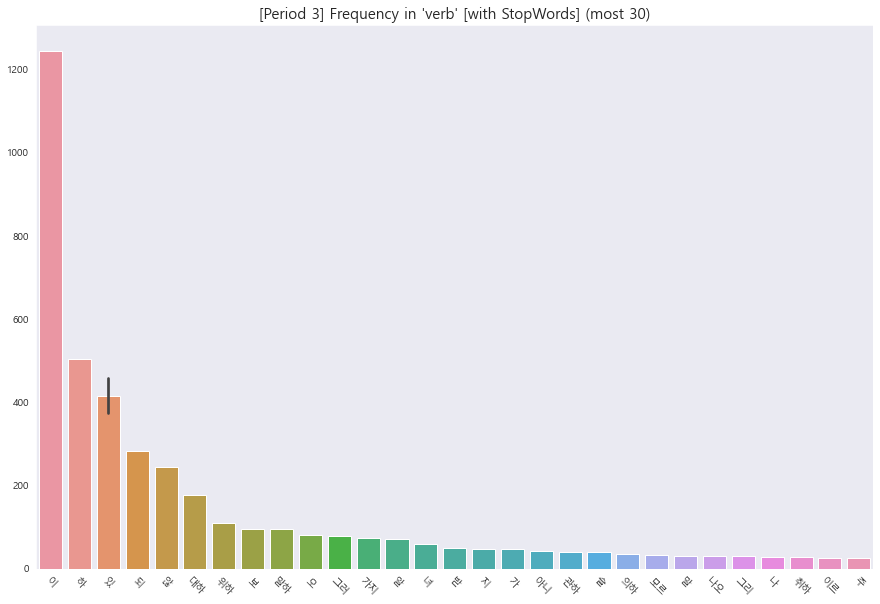

In [49]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-verb/', pos='verb', wo=False, period=3)

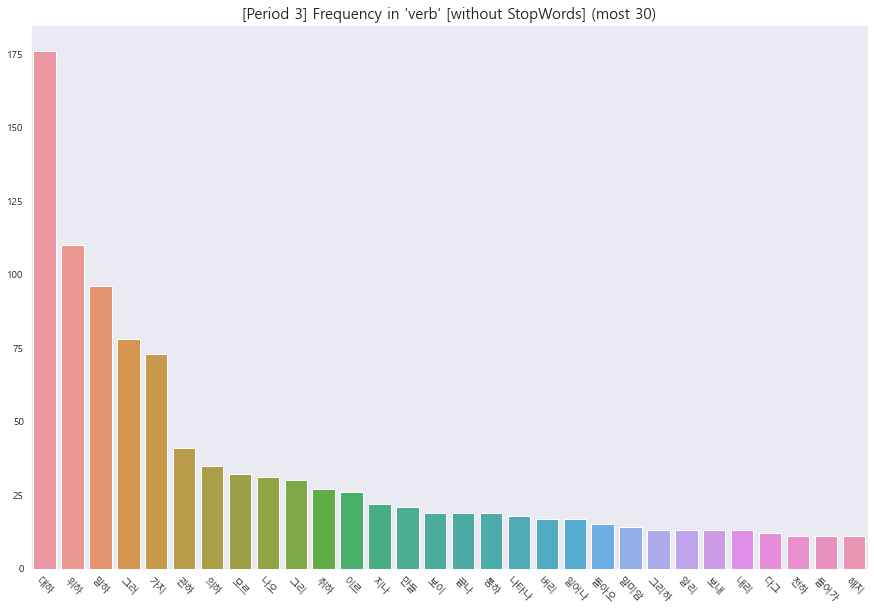

In [50]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-verb/', pos='verb', wo=True, period=3)

##### 분석 5) 'adjective'인 token들의 Frequncy (상위 30개)

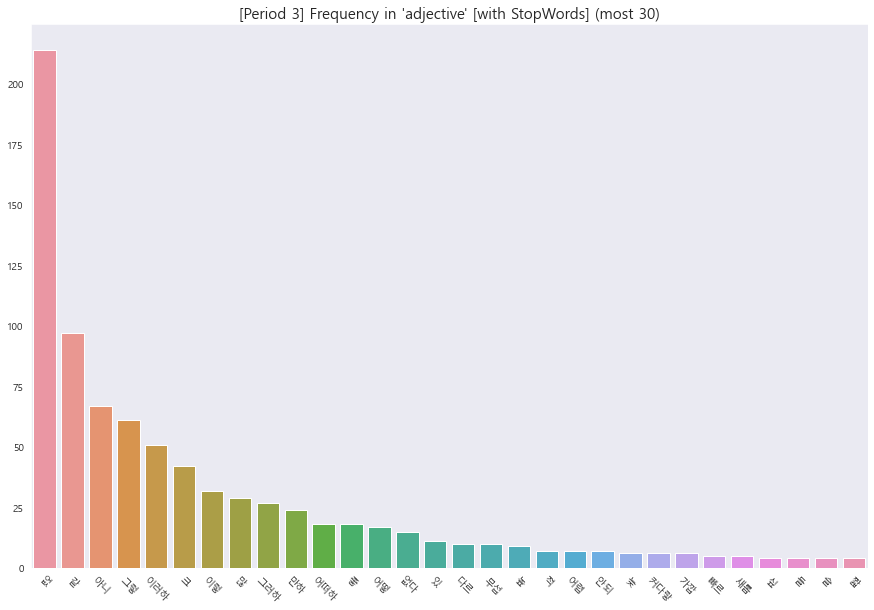

In [51]:
plotPOSFrequency(classDict_3, filepath=RESULT_3+'Frequency-in-adjective/', pos='adjective', wo=False, period=3)

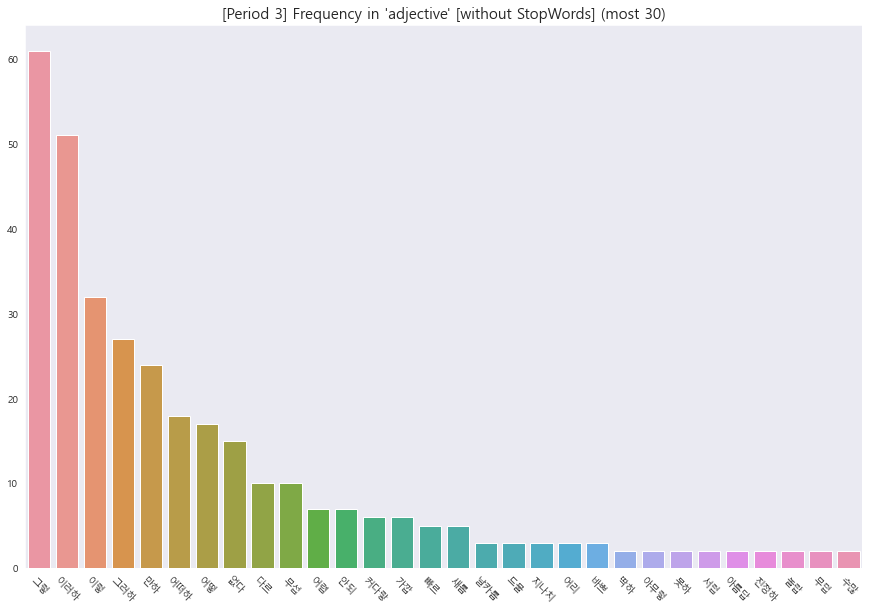

In [52]:
plotPOSFrequency(wo_classDict_3, filepath=RESULT_3+'Frequency-in-adjective/', pos='adjective', wo=True, period=3)

### 4-2. Topic Modeling (LDA)

#### Hyper-parameter 정의

- 각 시기 당 article의 수가 10개 였기 때문에 k=10으로 설정하고 모델링하였습니다.
- 적절한 k 값은 실험적으로 찾아보겠습니다.

In [53]:
NUM_TOPICS = 10
NUM_TOPIC_WORDS = 30

#### LDA Modeling을 위해 Noun만 추출하여 Tokenizing

In [54]:
noun_token_1 = tokenizing(wo_stopword_1, tagList, pos='noun')
noun_token_2 = tokenizing(wo_stopword_2, tagList, pos='noun')
noun_token_3 = tokenizing(wo_stopword_3, tagList, pos='noun')

#### Period 1

In [55]:
Corp, Dict = buildDTM(noun_token_1)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.008718  0.003743       1        1  24.306759
7      0.001952 -0.003801       2        1  21.206080
8     -0.007196 -0.004264       3        1  17.928713
0      0.004612 -0.003623       4        1  12.801792
4     -0.003438 -0.008159       5        1  10.947237
3      0.005484 -0.004673       6        1   8.166563
9     -0.006908  0.006901       7        1   4.629833
2      0.005072  0.000837       8        1   0.004341
5      0.002140  0.004982       9        1   0.004341
1      0.007002  0.008057      10        1   0.004341, topic_info=     Term        Freq       Total Category  logprob  loglift
703    소련  364.000000  364.000000  Default  30.0000  30.0000
442    미국  200.000000  200.000000  Default  29.0000  29.0000
592    사람  198.000000  198.000000  Default  28.0000  28.0000
1128   정부  115.000000  115.000000  Default  27.0000  27.0000
346    독일  121.000000  121.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1112   점령    0.001806   47.201232  Topic10  -6.3193  -0.1259
261    내가    0.001862   58.218553  Topic10  -6.2888  -0.3053
602    사실    0.001940   70.954634  Topic10  -6.2481  -0.4623
385   마니아    0.001958   80.546675  Topic10  -6.2388  -0.5798
338    도시    0.001740   48.910371  Topic10  -6.3566  -0.1988

[825 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2330      1  0.204444  가능성
2330      2  0.204444  가능성
2330      3  0.204444  가능성
2330      4  0.204444  가능성
2330      5  0.204444  가능성
...     ...       ...  ...
1496      3  0.203928  히틀러
1496      4  0.101964  히틀러
1496      5  0.135952  히틀러
1496      6  0.067976  히틀러
1496      7  0.067976  히틀러

[1827 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 9, 1, 5, 4, 10, 3, 6, 2])

#### Period 2

In [56]:
Corp, Dict = buildDTM(noun_token_2)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.010692  0.011353       1        1  37.008124
9      0.029604 -0.018840       2        1  15.604141
4     -0.031764  0.005117       3        1  14.333860
2     -0.005538 -0.012353       4        1  14.250053
5      0.035478  0.022826       5        1   9.474395
3     -0.021701 -0.005714       6        1   8.923337
0     -0.002792  0.004545       7        1   0.217713
8      0.000305 -0.008173       8        1   0.169341
1      0.014927 -0.005965       9        1   0.009518
7     -0.007825  0.007203      10        1   0.009517, topic_info=    Term        Freq       Total Category  logprob  loglift
225   미국  193.000000  193.000000  Default  30.0000  30.0000
428   영국   94.000000   94.000000  Default  29.0000  29.0000
506   자유   84.000000   84.000000  Default  28.0000  28.0000
350   소련  130.000000  130.000000  Default  27.0000  27.0000
532   전쟁  126.000000  126.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
48    경제    0.002860   50.686352  Topic10  -5.8570  -0.5229
588   중요    0.002260   30.081601  Topic10  -6.0923  -0.2364
532   전쟁    0.004226  126.830853  Topic10  -5.4664  -1.0494
506   자유    0.003320   84.248374  Topic10  -5.7078  -0.8817
216   목적    0.002194   29.364547  Topic10  -6.1221  -0.2421

[775 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.401699   가능
0         2  0.150637   가능
0         3  0.100425   가능
0         4  0.100425   가능
0         5  0.100425   가능
...     ...       ...  ...
749       2  0.128968   희랍
749       3  0.300925   희랍
749       4  0.128968   희랍
749       5  0.042989   희랍
749       6  0.085979   희랍

[1326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 5, 3, 6, 4, 1, 9, 2, 8])

#### Period 3

In [57]:
Corp, Dict = buildDTM(noun_token_3)
model = models.ldamodel.LdaModel(Corp, num_topics = NUM_TOPICS, id2word=Dict)
topicdf = topicWords(model, NUM_TOPIC_WORDS)

data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.007227 -0.013756       1        1  30.434961
9     -0.022464 -0.009336       2        1  26.558439
2      0.003560  0.019370       3        1  17.752868
4      0.012904 -0.008432       4        1  12.091590
5     -0.008534 -0.002103       5        1   9.114154
3     -0.009055  0.003584       6        1   1.641072
7      0.014915 -0.006124       7        1   1.487008
6     -0.005435  0.005941       8        1   0.905734
1     -0.000354  0.001435       9        1   0.007087
8      0.007235  0.009422      10        1   0.007087, topic_info=     Term        Freq       Total Category  logprob  loglift
312    소련  186.000000  186.000000  Default  30.0000  30.0000
217    미국  252.000000  252.000000  Default  29.0000  29.0000
152   대통령  109.000000  109.000000  Default  28.0000  28.0000
216    문제   93.000000   93.000000  Default  27.0000  27.0000
272    사람   78.000000   78.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
681    회의    0.002544   42.037691  Topic10  -6.0707  -0.1580
85     국민    0.003112   69.335175  Topic10  -5.8692  -0.4569
495    정부    0.003337   85.528063  Topic10  -5.7995  -0.5971
1143   주의    0.002561   44.859504  Topic10  -6.0639  -0.2162
481    전쟁    0.002367   82.266948  Topic10  -6.1427  -0.9014

[797 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3065      3  0.714202   가난
2841      2  0.684222   가든
1273      1  0.302852  가운데
1273      2  0.302852  가운데
1273      3  0.227139  가운데
...     ...       ...  ...
690       2  0.423709   희망
690       3  0.105927   희망
690       4  0.105927   희망
690       5  0.105927   희망
4024      2  0.566643  희망적

[1314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 3, 5, 6, 4, 8, 7, 2, 9])

### 4-3. WordCloud

#### Period 1

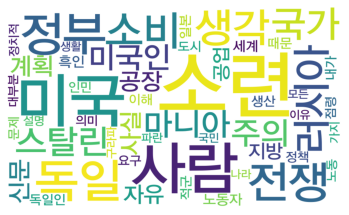

In [58]:
plotWordCloud(merge(noun_token_1), RESULT_1 + 'WordCloud')

#### Period 2

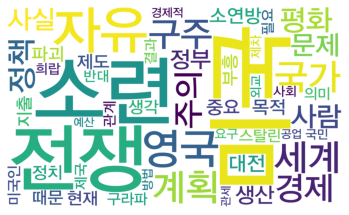

In [59]:
plotWordCloud(merge(noun_token_2), RESULT_2 + 'WordCloud')

#### Period 3

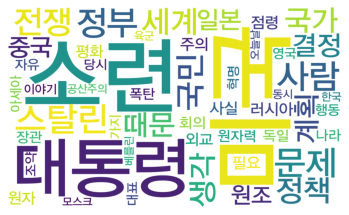

In [60]:
plotWordCloud(merge(noun_token_3), RESULT_3 + 'WordCloud')

### 4-4. Network web analysis

In [61]:
# result = (list(apriori(tokenized_1, min_support=0.01)))

In [62]:
# df = pd.DataFrame(result)
# df['length'] = df['items'].apply(lambda x: len(x))
# df = df[(df['length'] == 2) & \
#     (df['support'] >= 0.01)].sort_values(by='support', ascending=False)
# df.head(10)